<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/SelectUsableImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SelectUsableImages is a ONE-TIME notebook that creates a model to select usable images of cats.

Train a VGG16 model pre-trained on the ImageNet set of 14 million images to classify images as either usable or unusable for the feral cat census.  At this time (September 2023), a usable image is one with a single cat.  All other images are deemed unusable.

Sources for the code:
"[Transfer Learning with VGG16 and Keras](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)" by Gabriel Cassimo

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
input_shape = (244,244, 3) ## Pixel size of images, in each of 3 channels

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


In [37]:
# Add the layers to the VGG16 model that will be trained to distinguish
# usable from unusable images
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(128, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
dense_layer_3 = layers.Dense(8, activation='relu')

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
dropout_layer = layers.Dropout(0.5)

# Last layer is binary classification so we use sigmoid activation
prediction_layer = layers.Dense(1, activation='sigmoid')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dropout_layer,
    dense_layer_3,
    prediction_layer
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [3]:
## Set up ImageDataGenerator to randomly generate small tweaks to the training images.
## This improves the robustness of the model and increases the size of the
## training data set, which in our case is rather small.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               # No need to rescale -- this was done in the move_image function
                               # in the move_files_to_idg_folder.py script.
                               # rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [5]:
## Set up the paths to the training and test data sets.  These are arranged
## to be used by the IDG's flow_from_directory method.

from google.colab import drive
drive.mount('/content/gdrive')
file_path = '/content/gdrive/My Drive/Cat images/ImageDataGenerator_images/'
train_path = file_path + 'train'
test_path = file_path + 'test'


Mounted at /content/gdrive


In [40]:
image_gen.flow_from_directory(train_path)

Found 2678 images belonging to 2 classes.


In [41]:
image_gen.flow_from_directory(test_path)

Found 701 images belonging to 2 classes.


In [42]:
## Train the model, using early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [43]:
batch_size = 32
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=input_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 2678 images belonging to 2 classes.


In [44]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=input_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 701 images belonging to 2 classes.


In [13]:
train_image_gen.class_indices

{'unusable': 0, 'usable': 1}

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
84/84 [==============================] - 76s 884ms/step - loss: 1.7064 - accuracy: 0.5997 - val_loss: 0.4909 - val_accuracy: 0.5392
Epoch 2/20
84/84 [==============================] - 70s 840ms/step - loss: 0.5123 - accuracy: 0.7711 - val_loss: 0.2497 - val_accuracy: 0.8902
Epoch 3/20
84/84 [==============================] - 70s 832ms/step - loss: 0.4355 - accuracy: 0.8275 - val_loss: 0.2367 - val_accuracy: 0.9272
Epoch 4/20
84/84 [==============================] - 76s 912ms/step - loss: 0.3083 - accuracy: 0.8693 - val_loss: 0.2086 - val_accuracy: 0.9544
Epoch 5/20
84/84 [==============================] - 72s 856ms/step - loss: 0.2983 - accuracy: 0.8794 - val_loss: 0.1821 - val_accuracy: 0.9472
Epoch 6/20
84/84 [==============================] - 72s 854ms/step - loss: 0.2689 - accuracy: 0.9104 - val_loss: 0.1640 - val_accuracy: 0.9586
Epoch 7/20
84/84 [==============================] - 77s 919ms/step - loss: 0.2340 - accuracy: 0.9108 - val_loss: 0.1625 - val_accuracy: 0.9501

<Axes: >

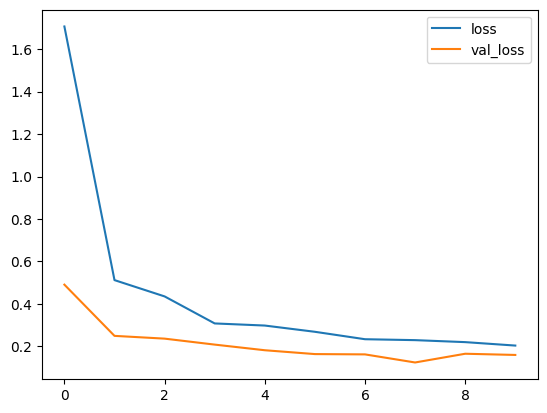

In [46]:
## Evaluate the model
import pandas as pd

losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [17]:
model.metrics_names

['loss', 'accuracy']

In [47]:
model.evaluate_generator(test_image_gen)

[0.10516435652971268, 0.9572039842605591]

In [48]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [49]:
pred_probabilities

array([[1.76021011e-08],
       [4.85401772e-31],
       [5.39541617e-03],
       [1.19807307e-21],
       [3.60929109e-09],
       [2.35782061e-09],
       [9.22576300e-23],
       [3.95536350e-15],
       [1.73683176e-04],
       [5.73317567e-03],
       [4.54474652e-10],
       [4.80962668e-19],
       [4.32770519e-13],
       [9.77044553e-02],
       [4.39684391e-02],
       [5.13133966e-18],
       [3.89328636e-02],
       [3.96661431e-04],
       [4.25705284e-01],
       [1.56244457e-01],
       [2.22084720e-13],
       [8.08017649e-28],
       [1.01784663e-14],
       [1.15169977e-23],
       [1.72918431e-29],
       [8.36263800e-18],
       [9.02402753e-05],
       [1.68479461e-13],
       [1.95440799e-12],
       [0.00000000e+00],
       [3.88976423e-06],
       [1.15919904e-20],
       [9.66222080e-21],
       [4.67220206e-21],
       [5.03303753e-38],
       [6.56378996e-09],
       [4.17724193e-19],
       [1.95390463e-16],
       [8.56290804e-19],
       [1.17441746e-19],


In [50]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [51]:
predictions = pred_probabilities > 0.5

In [52]:
predictions

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [24]:
from sklearn.metrics import classification_report,confusion_matrix

In [53]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.99      0.93      0.95       366
           1       0.92      0.99      0.95       335

    accuracy                           0.95       701
   macro avg       0.95      0.96      0.95       701
weighted avg       0.96      0.95      0.95       701



In [54]:
confusion_matrix(test_image_gen.classes,predictions)

array([[339,  27],
       [  5, 330]])

In [19]:
from tensorflow.keras.models import save_model, load_model

In [56]:
model.save('/content/gdrive/My Drive/Cat images/models/select_usable_images.keras')

Reload the saved model and run some raw images to check the predictions

In [20]:
reloaded_model = load_model('/content/gdrive/My Drive/Cat images/models/select_usable_images.keras')

In [32]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from matplotlib.image import imread

In [34]:
import tensorflow as tf
from tensorflow.keras import layers

# We're reading raw images, so transform them by normalizing the pixels
# and resizing the image as expected by the VGG model
transformer_nn = tf.keras.Sequential([
        layers.Resizing(244,244),
        layers.Rescaling(1./255)])

In [24]:
unusable_image = imread('/content/gdrive/My Drive/Cat images/kaggle_cats/00000507_009.jpg')

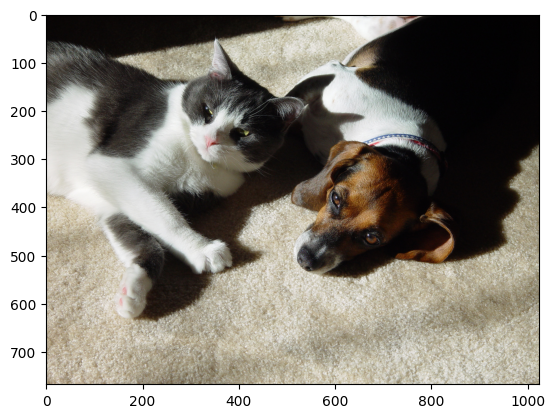

In [27]:
plt.imshow(unusable_image)

In [28]:
type(unusable_image)

numpy.ndarray

In [29]:
unusable_image.shape

(768, 1024, 3)

In [35]:
# Transform the image by resizing and rescaling
unusable_image_resized = transformer_nn(unusable_image)

In [37]:
unusable_image_resized.shape

TensorShape([244, 244, 3])

In [40]:
# Convert tensor to numpy array
unusable_image_resized = unusable_image_resized.numpy()

In [41]:
type(unusable_image_resized)

numpy.ndarray

In [45]:
# Turn the image into a batch of 1
unusable_image_batch = np.expand_dims(unusable_image_resized, axis=0)

In [46]:
unusable_image_batch.shape

(1, 244, 244, 3)

In [48]:
# Preidct the batch outcome
reloaded_model.predict(unusable_image_batch)[0] > .5

1/1 [==============================] - 8s 8s/step


array([False])

In [95]:
train_image_gen.class_indices

{'unusable': 0, 'usable': 1}

In [96]:
test_image_gen.class_indices

{'unusable': 0, 'usable': 1}